# Evolving a Lunar Lander with differentiable Genetic Programming

In [4]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

import numpy as np
import csv
import shutil
import os
from datetime import datetime
from sympy import simplify

### Creating the leaf nodes
The gym environment returns states that represent where the lunar lander is at the current frame. These states are used to calculate the next move of the lander. For each state, we create a leaf node that can be used in the tree that represent the solution.

In [5]:
# Create environment to find how many features it returns
env = gym.make("LunarLander-v2", continuous=True)
num_features = env.observation_space.shape[0]

# Create a feature for each value the evironment returns
leaf_nodes = [Feature(i) for i in range(num_features)]
# Add random constants to the features
leaf_nodes = leaf_nodes + [Constant()] 


## Checking and setting up gpu usage

In [6]:
cuda = torch.cuda.is_available()
print(cuda)

True


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
print(device)
a = torch.zeros(4,3)    
a = a.to(device)
# print(torch.cuda.set_device(1) )

cuda:0


In [8]:
!pip install pycuda
import torch
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU

'Quadro P1000'

sets it to first one, aka intel hd stuff

In [9]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Use GPU 0
else:
    device = torch.device("cpu")     # Use CPU

# Set the device for tensors
torch.cuda.set_device(device)


In [10]:
# cuda.Device(0).name()
# torch.Device(0).name()
# torch.device("cuda:0")

set it to gpu

In [11]:
# import torch

# # Check if CUDA is available
# if torch.cuda.is_available():
#     device = torch.device(torch.cuda.get_device_name(0))  # Use GPU 0
#     # device = torch.device(cuda.Device(0))
    
# else:
#     device = torch.device("cpu")  # Use CPU

# # Set the device for tensors
# torch.cuda.set_device(device)


In [12]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device_index = 0  # Replace with the index of your GPU
    device = torch.device('cuda:' + str(device_index) if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

# Set the device for tensors
torch.cuda.set_device(device)


In [13]:
import torch

# Check the current device
device = torch.cuda.current_device()
print("Current device:", torch.cuda.get_device_name(device))


Current device: Quadro P1000


In [14]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [15]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
      self.memory += other.memory
      return self 

    def __add__(self, other):
      self.memory = self.memory + other.memory 
      return self

In [16]:
frames = []

In [17]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards = []

  for _ in range(num_episodes):
    # get initial state of the environment
    observation = env.reset()
    observation = observation[0]
    
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      
      action = torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item())
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break

  fitness = np.sum(rewards)
  
  return fitness, memory

GPU attempt up population

In [18]:
# num_features = env.observation_space.shape[0]
# leaf_nodes = [Feature(i) for i in range(num_features)]
# leaf_nodes = leaf_nodes + [Constant()] # Think about the probability of sampling a coefficient
# internal_nodes = [Plus(),Minus(),Times(),Div(), Log()] #Add your own operators here

# evo = Evolution(
#   fitness_function_pt, internal_nodes, leaf_nodes,
#   4, # default is 4, number of trees in multitree
#   pop_size=1024,
#   max_gens=3,
#   max_tree_size=64,
#   n_jobs=6,
#   verbose=True)
# evo.evolve()

## Creating CSV


In [19]:
# Atomic funtions for the baseline solution
internal_nodes_base = [Plus(),Minus(),Times(),Div(),Log()]
leaf_nodes_base = leaf_nodes # as defined at the beginning

In [20]:
def Looper(var_to_change, runs=5):
    # runs = 5
    max_gens = 70
    Fittest =np.zeros([runs,max_gens])
    #TODO: Set to proper baseline values
    for i in range(runs):
        evo = Evolution(
            fitness_function_pt, internal_nodes_base, leaf_nodes_base, 4,
            pop_size=16, 
            # max_gens=70, 
            max_gens=1,
            max_tree_size=32, 
            n_jobs=6, verbose=True,
            init_max_depth = 4,
            # max_tree_size : int=64,
            # crossover = [{"fun":subtree_crossover, "rate": 0.5}],
            # crossovers = 0.4,
            # mutations = 0.5,
            # coeff_opts = 0.5,
            # selection = 8,
        )
        evo.evolve()
        # evo = Evolution(
        # lander_fitness_function_symmetry_feedback, internal_nodes_base, leaf_nodes, 
        # pop_size=200,
        # max_gens=70, # change also the one outside the loop
        # max_tree_size=64,
        # n_jobs=4,
        # verbose=True,
        # mutations  = [{"fun":subtree_mutation, "rate": 0.5}],
        # crossovers = [{"fun":subtree_crossover, "rate": 0.4}],
        # # coeff_opts = [{"fun":coeff_mutation, "rate": 0.0}],
        # # selection = {"fun":tournament_selection,"kwargs":{"tournament_size":var_to_change}},
        # )
        # evo.evolve()

        with open('gen.csv', 'r') as f:
            csv_reader = csv.reader(f, delimiter='\t')
            idx=0
            for row in csv_reader:
                Fittest[i, idx] =  float(row[1])
                idx+=1    
        (dt, micro) = datetime.utcnow().strftime('%Y%m%d%H%M%S.%f').split('.')
        shutil.copyfile('gen.csv', 'gen'+dt+str(int(var_to_change))+'.csv')
        os.remove('gen.csv')
    Fit_summation = np.sum(Fittest,axis=0)/runs
    print(sum(Fit_summation))

    plt.title('Fitness')
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.plot(range(max_gens),Fit_summation)

    (dt, _) = datetime.utcnow().strftime('%Y%m%d%H%M%S.%f').split('.')
    plt.savefig('gen_plot_baseline'+dt+str(int(var_to_change))+'.png', format='png', dpi=300) #!!! manually set a name)
    plt.show()
    return evo

gen: 1, 	best of gen fitness: -409.367,	best of gen size: 23
mean = -1206.02, 	median = -931.70, 	best_median = -931.70

-943.8787000688387


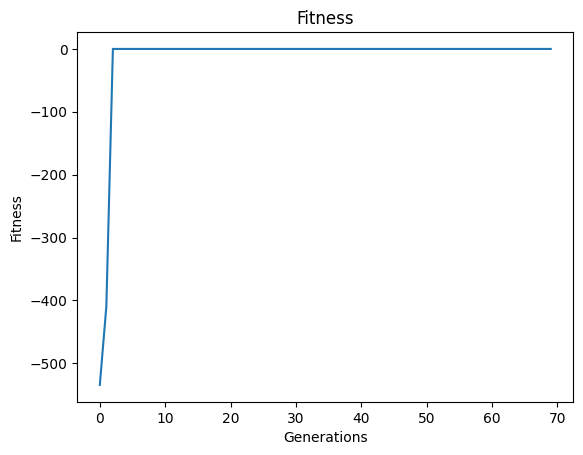

In [21]:
evo = Looper(1,1)
# evo = Looper(1,5)

## Saving models


In [22]:
import pickle

with open('baseline.pickle', 'wb') as file:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(evo, file, pickle.HIGHEST_PROTOCOL)

# Plots from fitnesses.csv


In [23]:
def plot(file, every_nth=1, title=None):
    fitnesses = []
    # store all fitnesses in a list
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        for row in csv_reader:
            fitnesses.append(row)
    fitnesses_array = np.array(fitnesses, dtype=np.float32)  # Transpose for boxplot
    filtered_fit_array = np.ma.masked_invalid(fitnesses_array).T

    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 8))
    ax.set_xlabel("Generation")
    plt.boxplot(filtered_fit_array[:,::every_nth], showfliers=False)
    # plt.xticks(np.arange(0, len(fitnesses), every_nth))
    labels, _ = plt.xticks()
    plt.xticks(labels, labels*every_nth-every_nth)
    if title is not None:
        plt.title(str(title))
    plt.savefig('fig1.png')
    plt.show()

# Manual renaming of the file to be plotted
plot('fitnesses_baseline_v1.csv', every_nth=2, title='Baseline')

FileNotFoundError: [Errno 2] No such file or directory: 'fitnesses_baseline_v1.csv'

Plot fitness for one run

In [25]:
import pandas as pd
data = {    'gen':                 [],
            'Fit_best': [],
            'Size_best':    [],    }

df = pd.DataFrame(data)
with open('gen.csv', 'r') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for row in csv_reader:
        df = df.append({'gen': row[0], 'Fit_best': row[1], 'Size_best': row[2]}, ignore_index=True)
        #TODO update to concat   

AttributeError: 'DataFrame' object has no attribute 'append'

# Manage gifs and improved output


In [26]:
multirun_fitness = []
for indiv in evo.population:
    multirun_fitness.append(fitness_function_pt(indiv,num_episodes=250))
    
max_multirun_fitness = max(multirun_fitness)
best_indiv = evo.population[np.argmax(multirun_fitness)]

NameError: name 'lander_fitness_function' is not defined

In [27]:
import os
import glob
files = sorted(glob.glob("*.gif"),key=os.path.getmtime)
export_gif = files[0]
print(export_gif)

IndexError: list index out of range

In [28]:
def get_frames_of_behavior(individual):
  """
  Runs the individual on the environment (using the fitness function with render=True) and creates a .gif
  """
  fitness, frames = fitness_function_pt(individual, num_episodes=5, render=True, ignore_done=True)
  save_frames_as_gif(frames, filename="lander_"+str(fitness)+".gif")
  save_frames_as_gif(frames, filename="lander_new.gif")

In [29]:
def get_frames_of_behavior2(individual):
  """
  Runs the individual on the environment (using the fitness function with render=True) and creates a .gif
  """
  fitness, frames = fitness_function_pt(individual, num_episodes=5, render=True, ignore_done=True)
  save_frames_as_gif(frames, filename="lander_"+str(fitness)+".gif")
  print(fitness)

In [30]:
best = evo.best_of_gens[-1]
get_frames_of_behavior2(best)

NameError: name 'lander_fitness_function' is not defined

In [ ]:
best = evo.best_of_gens[-1]
print(best.get_readable_repr())
print(best.get_output(np.random.rand(1,8)))
print(best._get_child_outputs(np.random.rand(1,8)))

In [ ]:
get_frames_of_behavior(best)

Newest lander gif (commented)
<img src="lander_new.gif" width="750" align="center">

In [ ]:
from IPython.display import Image
Image(url='lander_new.gif')  

Simplify representation

In [31]:
best_ext_input = ext_input_evo.best_of_gens[-1]
# get_frames_of_behavior(best_ext_input, save_as="best_ext_input", fitness_func=lander_fitness_function_prev_action)
get_frames_of_behavior(best_ext_input, save_as="best_ext_input")
fitness_function_pt

simpl_repr = simplify(best_ext_input.get_readable_repr())
print(f"The best solution is: {simpl_repr}")

NameError: name 'ext_input_evo' is not defined

## Plots from fitenesses.csv

In [32]:
def fitBoxplot(file, every_nth=1):
    fitnesses = []
    # store all fitnesses in a list
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        for row in csv_reader:
            fitnesses.append(row)
    fitnesses_array = np.array(fitnesses, dtype=np.float32)  # Transpose for boxplot
    filtered_fit_array = np.ma.masked_invalid(fitnesses_array).T

    fig = plt.figure(figsize=(10,5))  # Use this to size the figure
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel("Generation")
    plt.boxplot(filtered_fit_array[:,::every_nth], showfliers=False)
    # plt.xticks(np.arange(0, len(fitnesses), every_nth))
    labels, _ = plt.xticks()
    plt.xticks(labels, labels*every_nth-every_nth)
    plt.show()



In [33]:
files = sorted( glob.glob("fitness*.csv"),key=os.path.getmtime )
for file in files:
    fitBoxplot(file, every_nth=5)
# This file is on my pc only, get your own fitness file by runing and evlution with save_fitnesses=True
# plot('fitnesses20220617003333.csv', every_nth=5)


## Merge runs

In [34]:
runs = 5
max_gens = 70 
Fittest =np.zeros([runs,max_gens]) # initialize array to store fitness values
i = 0
j = 0
# Fit_summation = np.zeros([10, max_gens])
Fit_summation = {}
files = sorted( glob.glob("*.csv"),key=os.path.getmtime )
# values = [ 1,2,3,4,5,6,7,8 ]

for file in files:
    # value = file.replace(".csv", "")	# max tree size value
    # print(file[17:])
    # value = value[17:]
    # value = values[j]
    value = file.replace(".csv", "")	# max tree size value
    value = value.split("_")[0]
    # print(value)
    # if j < 8:
    #     value = values[j]

    with open(file, 'r') as f: # open one csv file for a run
        csv_reader = csv.reader(f, delimiter='\t')
        idx=0
        for row in csv_reader:
            try:
                Fittest[i, idx] =  float(row[1])   # fitness for that generation and run
            except:
                print("error")
                print(file)
                print(row)
            idx+=1    # generation number

    i += 1

    if i == 3:
        # print(value)
        i = 0
        j += 1
        # Fit_summation[,:] = np.sum(Fittest,axis=0)/5   # one vector with the average of all fitness values for that max tree size
        # Fit_summation = {value:np.sum(Fittest,axis=0)/5}   # one vector with the average of all fitness values for that max tree size
        # Fit_summation.append(value:np.sum(Fittest,axis=0)/5)   # one vector with the average of all fitness values for that max tree size
        new_csv = {value:np.sum(Fittest,axis=0)/5} 
        Fit_summation.update(new_csv)   # one vector with the average of all fitness values for that max tree size
        # Fit_summation[int(value)].append([np.sum(Fittest,axis=0)/5])   # one vector with the average of all fitness values for that max tree size
        # save the data in a csv file of the average fitness values
        with open('gen_merge_' + str(value) + '.csv','a') as f1:
          writer = csv.writer(f1, delimiter='\t',lineterminator='\n',)
          writer.writerow( zip(range(max_gens), Fit_summation[value]) )    


In [35]:
files = sorted( glob.glob("*.csv"),key=os.path.getmtime )
values = [ 1,2,3,4,5,6,7,8,9,10]
a=b=c=d=e=f=g=h=j=k=0
for file in files:
    value = file.replace(".csv", "")	# max tree size value
    value = int(value[17:])
    print(file)
    print(value)
    if value == 1:
        a = a+1
        shutil.copyfile(file, str(value) + "_"+str(a)+'.csv')
    if value == 2:
        b = b+1
        shutil.copyfile(file, str(value) + "_"+str(b)+'.csv')
    if value == 3:
        c = c+1
        shutil.copyfile(file, str(value) + "_"+str(c)+'.csv')
    if value == 4:
        d = d+1
        shutil.copyfile(file, str(value) + "_"+str(d)+'.csv')
    if value == 5:
        e = e+1
        shutil.copyfile(file, str(value) + "_"+str(e)+'.csv')
    if value == 6:
        f = f+1
        shutil.copyfile(file, str(value) + "_"+str(f)+'.csv')
    if value == 7:
        g = g+1
        shutil.copyfile(file, str(value) + "_"+str(g)+'.csv')
    if value == 8:
        h = h+1
        shutil.copyfile(file, str(value) + "_"+str(h)+'.csv')
    if value == 9:
        j = j+1
        shutil.copyfile(file, str(value) + "_"+str(j)+'.csv')
    if value == 10:
        k = k+1
        shutil.copyfile(file, str(value) + "_"+str(k)+'.csv')

gen202306131210171.csv
1
gen202306131210411.csv
1
gen202306131211001.csv
1
gen202306131211201.csv
1
gen202306131211401.csv
1
gen202306131213251.csv
1
gen202306131213581.csv
1
gen202306131214251.csv
1
gen202306131214541.csv
1
gen202306131215201.csv
1


ValueError: invalid literal for int() with base 10: ''

1


KeyError: '1'

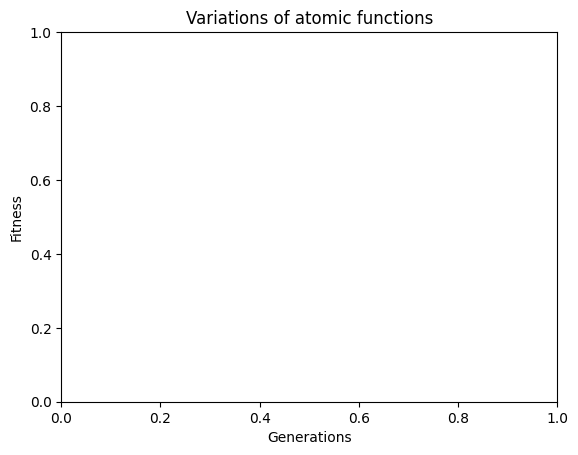

In [36]:
# values = [ 1,2,3,4,5,6,7,8]
# values = [1,3,5,7,8]
# values= [1,2,3,4,5,6,7,8,9,10]
values= ['1','2','3','4','5','6','7','8','9','10']
plt.figure( facecolor=(1, 1, 1) )
plt.title ("Variations of atomic functions")
plt.xlabel("Generations")
plt.ylabel("Fitness")
for val in values:
    print(val)
    # plt.plot( range(max_gens), Fit_summation[str(val)], label=str(val) )
    plt.plot( range(max_gens), Fit_summation[(val)], label=str(val) )
    legned = plt.legend(loc='lower right', shadow=True)
plt.savefig('gen_atomic_fitness.png', format='png', dpi=300)
plt.show()

In [37]:
runs = 5
max_gens = 70 
Fittest =np.zeros([runs,max_gens]) # initialize array to store fitness values
i = 0
j = 0
# Fit_summation = np.zeros([10, max_gens])
Fit_summation = {}
files = sorted( glob.glob("*.csv"),key=os.path.getmtime )
# values = [ 1,2,3,4,5,6,7,8 ]

for file in files:
    # value = file.replace(".csv", "")	# max tree size value
    # print(file[17:])
    # value = value[17:]
    # value = values[j]
    value = file.replace(".csv", "")	# max tree size value
    value = value.split("_")[0]
    print(value)
    # if j < 8:
    #     value = values[j]

    with open(file, 'r') as f: # open one csv file for a run
        csv_reader = csv.reader(f, delimiter='\t')
        idx=0
        for row in csv_reader:
            try:
                Fittest[i, idx] =  float(row[3])   # fitness for that generation and run
            except:
                print("error")
                print(file)
                print(row)
            idx+=1    # generation number

    i += 1

    if i == 3:
        # print(value)
        i = 0
        j += 1
        # Fit_summation[,:] = np.sum(Fittest,axis=0)/5   # one vector with the average of all fitness values for that max tree size
        # Fit_summation = {value:np.sum(Fittest,axis=0)/5}   # one vector with the average of all fitness values for that max tree size
        # Fit_summation.append(value:np.sum(Fittest,axis=0)/5)   # one vector with the average of all fitness values for that max tree size
        new_csv = {value:np.sum(Fittest,axis=0)/5} 
        Fit_summation.update(new_csv)   # one vector with the average of all fitness values for that max tree size
        # Fit_summation[int(value)].append([np.sum(Fittest,axis=0)/5])   # one vector with the average of all fitness values for that max tree size
        # save the data in a csv file of the average fitness values
        with open('gen_median_' + str(value) + '.csv','a') as f1:
          writer = csv.writer(f1, delimiter='\t',lineterminator='\n',)
          writer.writerow( zip(range(max_gens), Fit_summation[value]) )    


gen202306131210171
gen202306131210411
gen202306131211001
gen202306131211201
gen202306131211401
gen202306131213251
gen202306131213581
gen202306131214251
gen202306131214541
gen202306131215201
gen
gen202306131232211
gen
error
gen_merge_gen202306131211001.csv
['(0, -375.3122691272125)', '(1, 0.0)', '(2, 0.0)', '(3, 0.0)', '(4, 0.0)', '(5, 0.0)', '(6, 0.0)', '(7, 0.0)', '(8, 0.0)', '(9, 0.0)', '(10, 0.0)', '(11, 0.0)', '(12, 0.0)', '(13, 0.0)', '(14, 0.0)', '(15, 0.0)', '(16, 0.0)', '(17, 0.0)', '(18, 0.0)', '(19, 0.0)', '(20, 0.0)', '(21, 0.0)', '(22, 0.0)', '(23, 0.0)', '(24, 0.0)', '(25, 0.0)', '(26, 0.0)', '(27, 0.0)', '(28, 0.0)', '(29, 0.0)', '(30, 0.0)', '(31, 0.0)', '(32, 0.0)', '(33, 0.0)', '(34, 0.0)', '(35, 0.0)', '(36, 0.0)', '(37, 0.0)', '(38, 0.0)', '(39, 0.0)', '(40, 0.0)', '(41, 0.0)', '(42, 0.0)', '(43, 0.0)', '(44, 0.0)', '(45, 0.0)', '(46, 0.0)', '(47, 0.0)', '(48, 0.0)', '(49, 0.0)', '(50, 0.0)', '(51, 0.0)', '(52, 0.0)', '(53, 0.0)', '(54, 0.0)', '(55, 0.0)', '(56, 0.0)

1
2


KeyError: '2'

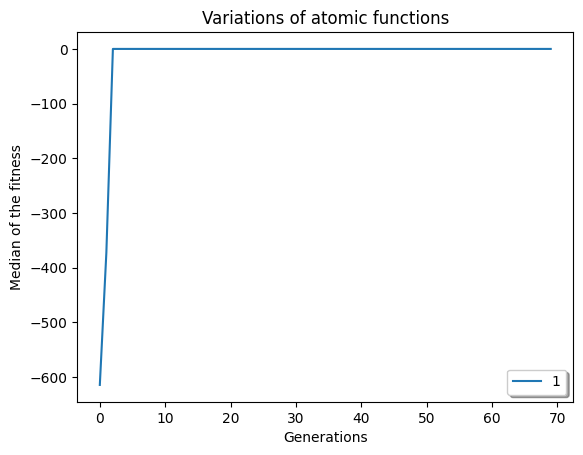

In [38]:
# values = [ 1,2,3,4,5,6,7,8]
# values = [1,3,5,7,8]
# values= [1,2,3,4,5,6,7,8,9,10]
values= ['1','2','3','4','5','6','7','8','9','10']
plt.figure( facecolor=(1, 1, 1) )
plt.title ("Variations of atomic functions")
plt.xlabel("Generations")
plt.ylabel("Median of the fitness")
for val in values:
    print(val)
    # plt.plot( range(max_gens), Fit_summation[str(val)], label=str(val) )
    plt.plot( range(max_gens), Fit_summation[(val)], label=str(val) )
    legned = plt.legend(loc='lower right', shadow=True)
plt.savefig('gen_atomic_median.png', format='png', dpi=300)
plt.show()

In [39]:
median = np.zeros([runs,max_gens])

# path = "gen2*10.csv"
path = "2_*.csv"
i=0
for filename in glob.glob(path):
    print(str(filename))
    with open(filename, 'r') as f:
        csv_reader = csv.reader(f, delimiter='\t')
        idx=0
        for row in csv_reader:
            median[i, idx] =  float(row[3])
            idx+=1
        i += 1
median_avg = np.mean(median,axis=0)
median_std = np.std(median, axis=0)
plt.errorbar(range(max_gens)+0.01,median_avg,yerr=median_std, fmt='-o',label="Method 2")
# path = "crossover/*.csv"
path = "10_*.csv"
i=0
for filename in glob.glob(path):
    print(str(filename))
    with open(filename, 'r') as f:
        csv_reader = csv.reader(f, delimiter='\t')
        idx=0
        for row in csv_reader:
            median[i, idx] =  float(row[3])
            idx+=1
        i += 1
median_avg = np.mean(median,axis=0)
median_std = np.std(median, axis=0)
plt.errorbar(range(max_gens)+0.01,median_avg,yerr=median_std, fmt='-o',label="Method 10")
plt.legend(loc="lower right")
plt.title('Atomic function variations')
plt.xlabel("Generations")
plt.ylabel("Median fitness")
plt.savefig('Luuk_atomic_median.png', format='png', dpi=300)
plt.show()

TypeError: unsupported operand type(s) for +: 'range' and 'float'

# Test

In [ ]:
def get_test_score(tree):
    rewards = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = action = torch.Tensor.argmax(output)# What goes here?
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.sum(rewards)
    
    return fitness

best = evo.best_of_gens[-1]

print(best.get_readable_repr())
print(get_test_score(best))

## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

In [ ]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [ ]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()

if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()

print(best.get_readable_repr())
print(get_test_score(best))

In [ ]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">